In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import math
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from numpyro.infer import MCMC, NUTS

import numpyro.distributions as dist

import arviz as az

In [52]:
class Wind:
    def __init__(self, speed, direction):
        self.speed = speed # a function over time
        self.direction = direction # a tuple in the form of (x,y)

    def angle(self): # the angle between the velocity and the east-west direction
        theta = math.atan2(self.direction[1], self.direction[0])
        return theta
  
    def velocity(self):
        x = self.speed * math.cos(self.angle())
        y = self.speed * math.sin(self.angle())
        return (x,y)

In [53]:
# only works for when the wind is moving towards the west; easy to modify to let the wind move in more directions but no need for here
# only works for small wind; increasing the size will allow larger wind but no need for here

class Signal:
    def __init__(self, N_p, lw, hi):
        self.input = np.random.uniform(low=lw, high=hi, size=2*N_p) # twice the pixels because the signal is moving

    def moving_velocity(self, wind):
        vel = wind.velocity()
        return vel

    def signal_func(self, time, wind, N_p): # one dimensional
        signal_t = []
        vel = self.moving_velocity(wind)[0]
        for i in range(N_p):
            if not(((i-int(time*vel)) < 0) or ((i-int(time*vel)) >= 2*N_p)):
                signal_t.append(self.input[i-int(time*vel)])
            else: 
                signal_t.append(None)
        # print(vel, time, int(time*vel))
        signal_t = np.array(signal_t)
        return signal_t

In [54]:
class Data:
    def __init__(self, signal, PM1, PM2, size):
        self.signal = signal
        self.PM1 = PM1
        self.PM2 = PM2
        self.size = size
        self.input_1 = None
        self.input_2 = None # used only to check the result to meth 1; does not work in reality since the wind is an unknown parameter

    def get_data_method_2(self):
        self.input_2 = self.signal[self.PM2]
        return self.input_2

    def add_small_noise(self):
        noise = np.random.randn(self.size) * 10
        if (self.input_1 is None):
            return self.input_2 + noise
        return self.input_1 + noise
    
    def add_large_noise(self):
        noise = np.random.randn(self.size) * 50
        if (self.input_1 is None):
            return self.input_2 + noise
        return self.input_1 + noise

In [55]:
# N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)
N_t, N_p = 150 * 10, 10

In [82]:
wind = Wind(0.5, (-1,0))
signal_pack = Signal(N_p, 5, 30)
signal = signal_pack.input

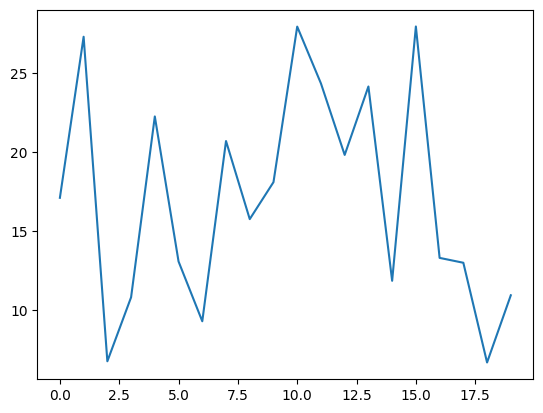

In [99]:
plt.plot(signal)

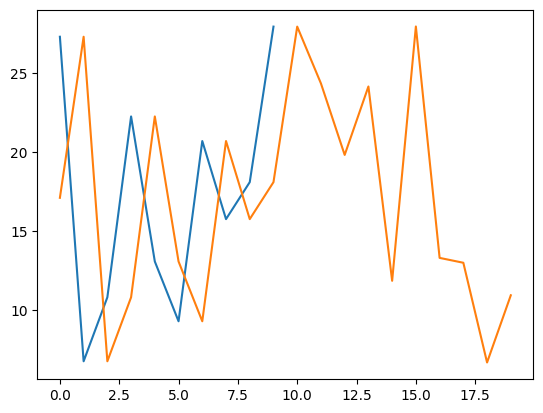

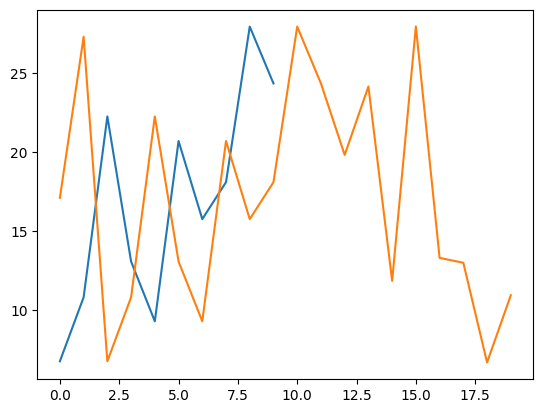

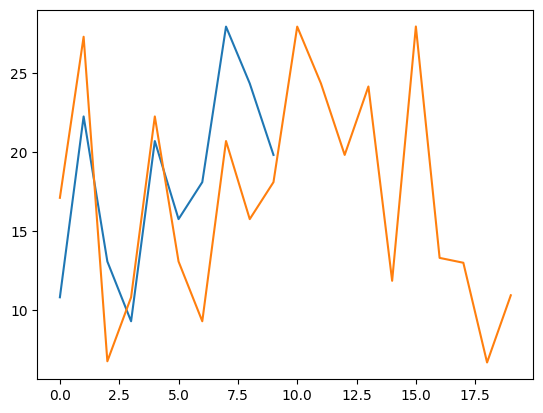

In [136]:
plt.plot(signal_pack.signal_func(2,wind, N_p))
plt.plot(signal)
plt.show()

plt.plot(signal_pack.signal_func(4,wind, N_p))
plt.plot(signal)
plt.show()

plt.plot(signal_pack.signal_func(6,wind, N_p))
plt.plot(signal)
plt.show()

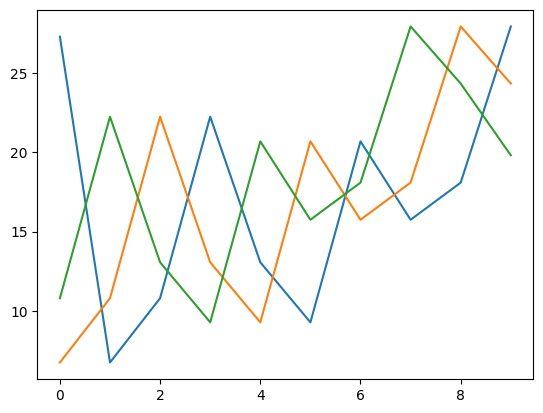

In [139]:
plt.plot(signal_pack.signal_func(2,wind, N_p))
plt.plot(signal_pack.signal_func(4,wind, N_p))
plt.plot(signal_pack.signal_func(6,wind, N_p))

In [58]:
# the original pointing matrix
P_encoded_org = list()
for row in range(N_t):
    for col in range(N_p):
            if ((row / 150) // (10 / 10) == col):
                P_encoded_org.append(col)
          
P_encoded_org = np.array(P_encoded_org)
print(np.shape(P_encoded_org))

# the pointing matrix adjusted for the shifting signal
P_encoded = list()
for row in range(N_t):
    for col in range(N_p*2):
            if ((row / 150) // (10 / 20) == col):
                P_encoded.append(col)        
P_encoded = np.array(P_encoded)
print(np.shape(P_encoded))

(1500,)
(1500,)


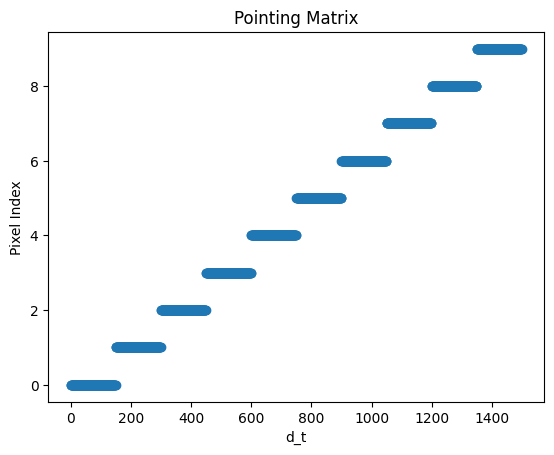

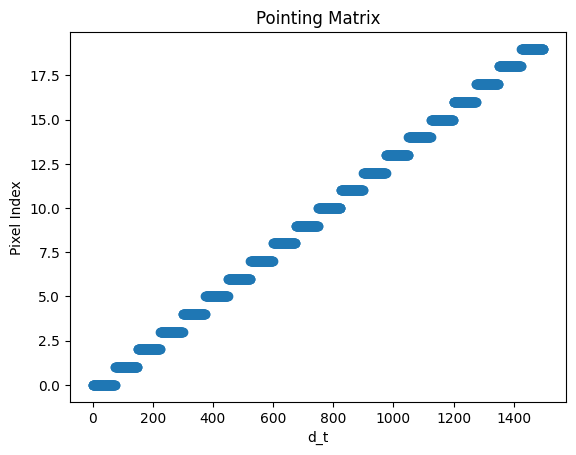

In [59]:
# check P_encoded

plt.scatter(range(len(P_encoded_org)), P_encoded_org)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

plt.scatter(range(len(P_encoded)), P_encoded)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

In [84]:
data_pack = Data(signal, P_encoded_org, P_encoded, N_t)

In [85]:
rng_key = random.PRNGKey(0)

Method 1 -- Make the signal in each pixel to a function over time

In [86]:
data_pack.input_2 = None

input_1 = []
for time_ind in range(N_t):
    output = signal_pack.signal_func(time_ind/150., wind, N_p)
    # print(np.shape(output))
    input_1.append(output[P_encoded_org][time_ind])
input_1 = np.array(input_1)

data_pack.input_1 = input_1

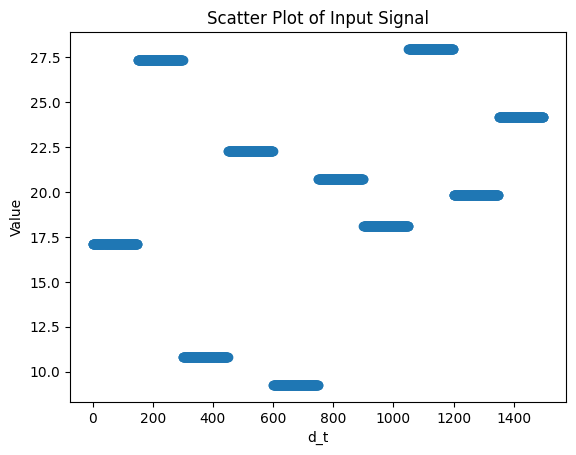

In [87]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input_1)), input_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [88]:
Data_small_noise_1 = data_pack.add_small_noise()
Data_large_noise_1 = data_pack.add_large_noise()

# Since CMB original signal is also Gaussian, it is safe to assume that it is part of the Gaussian noise.

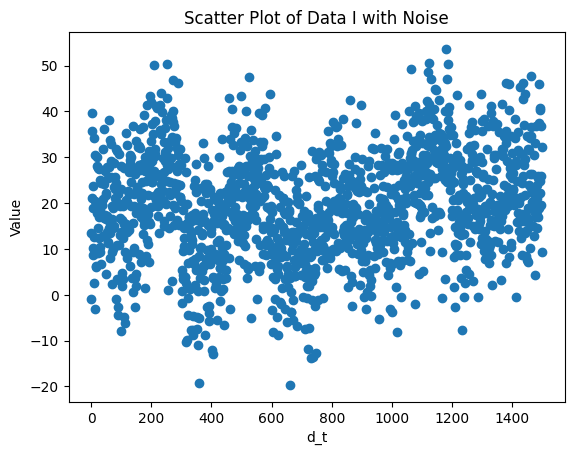

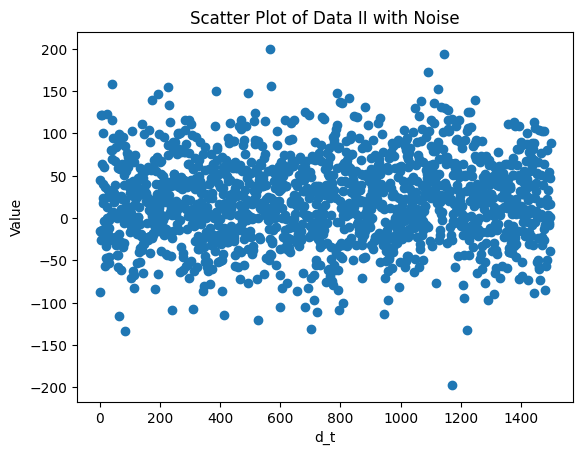

In [89]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise_1)), Data_small_noise_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise_1)), Data_large_noise_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [66]:
scale = 1

In [142]:
def sig_func_at_t_py(s,t,wind_speed):
    signal_t = []
    for i in range(N_p):
        signal_t.append(s[i-jnp.array(t*wind_speed, int)])
    # print(vel, time, int(time*vel))
    signal_t = jnp.array(signal_t)
    return signal_t

def sig_func_at_t_jax(s,t,wind_speed):
    shift = jnp.array(t * wind_speed, dtype=int)
    idx = jnp.arange(N_p) - shift
    signal_t = s[idx]
    # signal_t = s[idx+N_p*scale//2]
    return signal_t

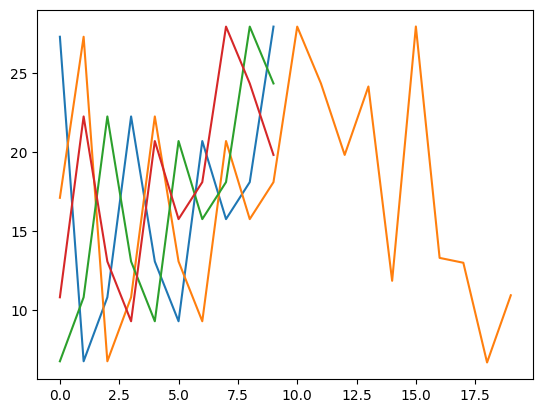

In [148]:
plt.plot(sig_func_at_t_jax(signal, 2, -0.5))
plt.plot(signal)

plt.plot(sig_func_at_t_jax(signal, 4, -0.5))
plt.plot(sig_func_at_t_jax(signal, 6, -0.5))

In [ ]:
# def shift_fft_1d(x, delta):
#     n = x.shape[0]
#     k = 2*jnp.pi*jnp.fft.fftfreq(n)
#     return jnp.fft.ifft(jnp.fft.fft(x) * jnp.exp(1j*k*delta)).real

# def sig_func_at_t_jax(s, t, wind_speed):
#     delta = t * wind_speed
#     return shift_fft_1d(s, delta)

In [164]:
signal_jax = jnp.array(signal)
Data_small_noise_1 = jnp.array(Data_small_noise_1)
P_encoded_org = jnp.array(P_encoded_org)

In [ ]:
## Check before Use, Expect 0.0 Output

from jax import vmap

# 1) Old Python-style generator
d_py = []
for time_ind in range(N_t):
    out_py = sig_func_at_t_py(signal, time_ind/150., -0.5)
    d_py.append(out_py[P_encoded_org][time_ind])
d_py = jnp.array(d_py)

# 2) New JAX-style generator using the same original signal, wind_true
time_inds = jnp.arange(N_t)

def step_fn(time_ind, s, wind_speed, P_encoded_org):
    t = time_ind / 150.0
    out_jax = sig_func_at_t_jax(s, t, wind_speed)
    return out_jax[P_encoded_org][time_ind]

d_jax = vmap(lambda ti: step_fn(ti, signal_jax, -0.5, P_encoded_org))(time_inds)

# 3) Check they are identical (up to float error)
print("max |d_py - d_jax| =", jnp.max(jnp.abs(d_py - d_jax)))

max |d_py - d_jax| = 0.0


In [189]:
# from jax import vmap
def model_func_1():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p,-30), high=jnp.full(N_p,100)))

        wind_speed = numpyro.sample("speed", dist.Uniform(-1.0,1.0))
        # wind_speed = -0.5
        
        # input = []
        # for time_ind in range(N_t):
        #         output = sig_func_at_t_py(s,time_ind/150., wind_speed)
        #         # print(np.shape(output))
        #         input.append(output[P_encoded_org][time_ind])
        # d = jnp.asarray(input)

        # def step_fn(time_ind, s, wind_speed, P_encoded_org):
        #         t = time_ind / 150.0
        #         output = sig_func_at_t_jax(s, t, wind_speed)
        #         return output[P_encoded_org][time_ind]

        # time_inds = jnp.arange(N_t)

        d = s[P_encoded_org]

        # d = jax.vmap(lambda ti: step_fn(ti, s, wind_speed, P_encoded_org))(time_inds)

        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise_1)

        # wind_speed = numpyro.sample("wind_speed", dist.Normal(wind_speed,1.), obs=Data_small_noise_1)

        return d_noised

nuts_kernel_1 = NUTS(model_func_1)
mcmc_1 = MCMC(nuts_kernel_1, num_warmup=100, num_samples=100)
mcmc_1.run(rng_key)

sample: 100%|██████████| 200/200 [00:00<00:00, 216.04it/s, 11 steps of size 9.67e-01. acc. prob=0.66]


In [184]:
signal_2 = []
for i in range(len(signal)):
    if ((i+1) % 3 != 0):
        signal_2.append(signal[i])

In [185]:
samples = mcmc_1.get_samples()
s_post_mean = jnp.mean(samples["s"], axis=0)

err = s_post_mean - jnp.array(signal_2)
print("max |s_post_mean - s_true| =", jnp.max(jnp.abs(err)))
print("RMSE =", jnp.sqrt(jnp.mean(err**2)))

def forward(s):
    time_inds = jnp.arange(N_t)
    return vmap(lambda ti: step_fn(ti, s, -0.5, P_encoded_org))(time_inds)

d_mean = forward(s_post_mean)
print("max |d_mean - Data_small_noise_1| =",
      jnp.max(jnp.abs(d_mean - Data_small_noise_1)))

TypeError: sub got incompatible shapes for broadcasting: (10,), (14,).

In [23]:
samples   = mcmc_1.get_samples()
wind_speed_est = samples["speed"]
speed_mean_est = jnp.mean(wind_speed_est)
print(speed_mean_est)

KeyError: 'speed'

In [24]:
plt.plot(samples["speed"])

KeyError: 'speed'

In [25]:
def model_func_2():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p,-30), high=jnp.full(N_p,100)))
        d = s[P_encoded_org]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise_1)
        return d_noised

nuts_kernel_2 = NUTS(model_func_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=100, num_samples=100)
mcmc_2.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 491.21it/s, 7 steps of size 6.60e-01. acc. prob=0.88]


In [186]:
trace_1 = az.from_numpyro(mcmc_1)
# trace_2 = az.from_numpyro(mcmc_2)

In [187]:
trace_1.posterior['s'].squeeze().shape
# trace_2.posterior['s'].squeeze().shape

(100, 10)

In [28]:
grid = jnp.linspace(-1,1,101)
ll = jnp.array([loglik_given_speed(s_fixed, spd) for spd in grid])
plt.plot(grid, ll - ll.max())

NameError: name 'loglik_given_speed' is not defined

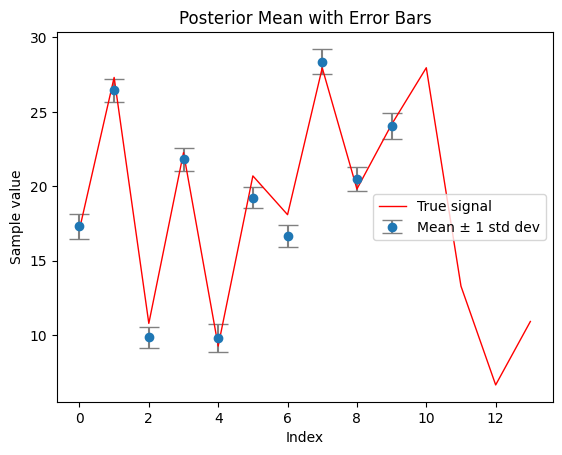

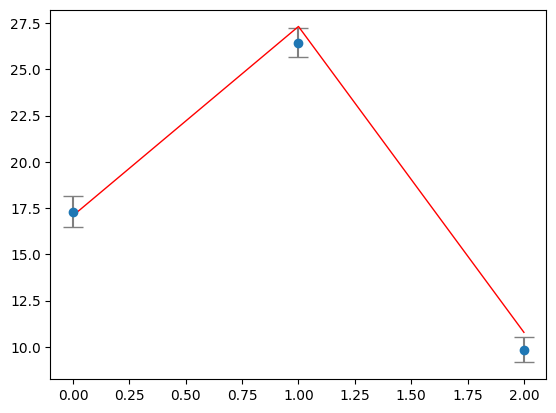

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_39982/3317503068.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


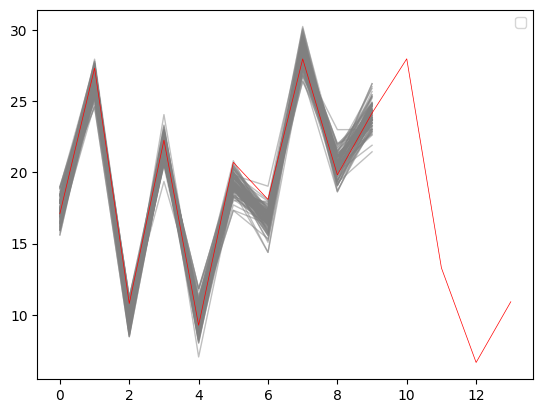

In [188]:
s_samples_1 = trace_1.posterior['s'].squeeze().values # shape: (num_of_samples, N_p)
s_mean_1 = np.mean(s_samples_1, axis=0) # shape: (N_p,)
s_std_1 = np.std(s_samples_1, axis=0) # shape: (N_p,)

x = np.arange(len(s_mean_1))

plt.errorbar(x, s_mean_1, yerr=s_std_1, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_1[0:3], yerr=s_std_1[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_1.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal_2, color='red', lw=0.5)
plt.legend()
plt.show()

In [191]:
Data_small_noise_1 = jnp.asarray(Data_small_noise_1, dtype=jnp.float32)
P_encoded_org      = jnp.asarray(P_encoded_org,      dtype=jnp.int32)

sigma = 10.0  # noise std in your Normal(d, 10.) likelihood


# -----------------------------------------
# 1. For a given speed, compute j_idx[t]
#    (which entry of s each time sample sees)
# -----------------------------------------
def j_idx_for_speed(speed: float) -> jnp.ndarray:
    """
    speed: scalar (float). Physically continuous.
    Returns j_idx[t] (int array of length N_t) such that
    data[t] ≈ s[j_idx[t]] + noise.
    """
    time_inds = jnp.arange(N_t)
    t_vals    = time_inds / 150.0  # same factor as in your model

    # Discrete shift in pixel units: int(t * speed)
    shifts = (t_vals * speed).astype(jnp.int32)

    # Underlying template index used at each time
    j_idx = P_encoded_org - shifts

    # If your physics wraps around the template, uncomment:
    # j_idx = jnp.mod(j_idx, N_p)

    return j_idx  # shape (N_t,)


# -----------------------------------------
# 2. MLE template s_hat for a given speed
# -----------------------------------------
def mle_s_for_speed(speed: float):
    """
    For a fixed speed, compute the MLE (and posterior mean) of the template s:
        d_t = s[j_idx[t]] + noise_t
        noise_t ~ N(0, sigma^2)
    s_hat[j] = average of all data[t] s.t. j_idx[t] == j.
    """
    j_idx = j_idx_for_speed(speed)
    d     = Data_small_noise_1  # shape (N_t,)

    # Accumulate sums and hit counts per pixel
    sum_s   = jnp.zeros(N_p)
    count_s = jnp.zeros(N_p)

    sum_s   = sum_s.at[j_idx].add(d)
    count_s = count_s.at[j_idx].add(1)

    # Avoid division by zero for pixels never hit; they don't affect likelihood
    s_hat = sum_s / jnp.maximum(count_s, 1)

    return s_hat, j_idx, count_s


# -----------------------------------------
# 3. Log-likelihood for a given speed
#    (profiled over s via s_hat)
# -----------------------------------------
def loglik_given_speed(speed: float) -> jnp.ndarray:
    """
    Profile log-likelihood log p(data | speed) using s_hat(speed).
    Constant terms in the Normal likelihood are dropped (OK for comparisons).
    """
    s_hat, j_idx, _ = mle_s_for_speed(speed)
    d   = Data_small_noise_1

    mu      = s_hat[j_idx]           # predicted mean at each time
    resid   = d - mu
    ll      = -0.5 * jnp.sum(resid**2) / sigma**2  # drop constant

    return ll


# Optional: JIT for speed
loglik_given_speed_jit = jax.jit(loglik_given_speed)


# -----------------------------------------
# 4. Grid search over speed + approximate posterior
# -----------------------------------------
def estimate_speed(grid_min=-1.0, grid_max=1.0, num_points=201):
    """
    Evaluate loglik_given_speed on a grid of speeds,
    return:
      - grid of speeds
      - log-likelihood at each grid point
      - MLE speed (max log-likelihood)
      - posterior mean and std over speed
    """
    grid = jnp.linspace(grid_min, grid_max, num_points)

    # You can use either the jit'ed or plain version
    ll_values = jnp.array([loglik_given_speed_jit(spd) for spd in grid])

    # MLE speed
    best_idx   = int(jnp.argmax(ll_values))
    best_speed = float(grid[best_idx])

    # Turn log-likelihoods into approximate posterior weights
    ll_shifted = ll_values - jnp.max(ll_values)        # for numerical stability
    w          = jnp.exp(ll_shifted)
    w          = w / jnp.sum(w)

    post_mean = float(jnp.sum(grid * w))
    post_var  = float(jnp.sum(w * (grid - post_mean)**2))
    post_std  = post_var**0.5

    return grid, ll_values, best_speed, post_mean, post_std


# -----------------------------------------
# 5. Run speed estimation
# -----------------------------------------
grid, ll_vals, speed_mle, speed_post_mean, speed_post_std = estimate_speed(
    grid_min=-1.0,
    grid_max=1.0,
    num_points=201  # change resolution if you want
)

print("Speed MLE         :", speed_mle)
print("Speed post. mean  :", speed_post_mean)
print("Speed post. std   :", speed_post_std)


Speed MLE         : -0.12000000476837158
Speed post. mean  : -0.02381598763167858
Speed post. std   : 0.07254261017927931


In [ ]:
s_samples_2 = trace_2.posterior['s'].squeeze().values
s_mean_2 = np.mean(s_samples_2, axis=0)
s_std_2 = np.std(s_samples_2, axis=0)

x = np.arange(len(s_mean_2))

plt.errorbar(x, s_mean_2, yerr=s_std_2, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_2[0:5], yerr=s_std_2[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal_2[:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_2.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal_2, color='red', lw=0.5)
plt.legend()
plt.show()

NameError: name 'trace_2' is not defined

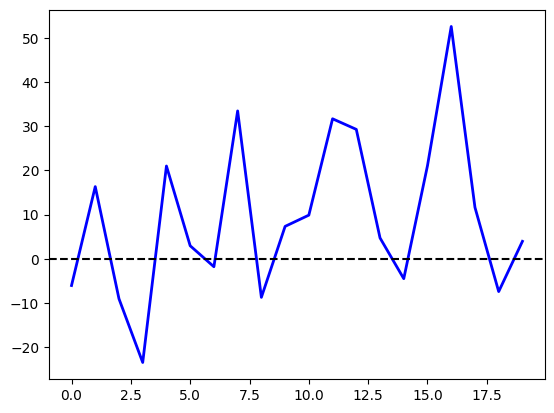

In [ ]:
plt.plot(s_mean_1 - signal[:20], color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

# plt.plot(s_mean_2 - signal_2[:10], color='blue', lw=2.0)
# plt.axhline(0, color='black', linestyle='--')
# plt.show()

Method 2 -- Frame a new set of pixels on the moving signal and take the relative speed of this new set of pixels with the detectors

In [ ]:
input_2 = data_pack.get_data_method_2()
data_pack.input_1 = None

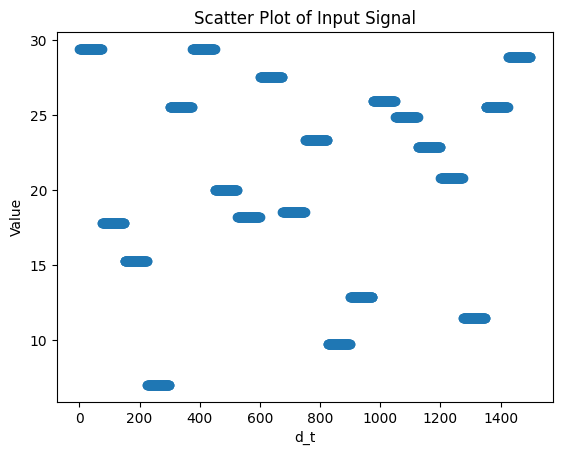

In [ ]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input_2)), input_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [ ]:
Data_small_noise_2 = data_pack.add_small_noise()
Data_large_noise_2 = data_pack.add_large_noise()

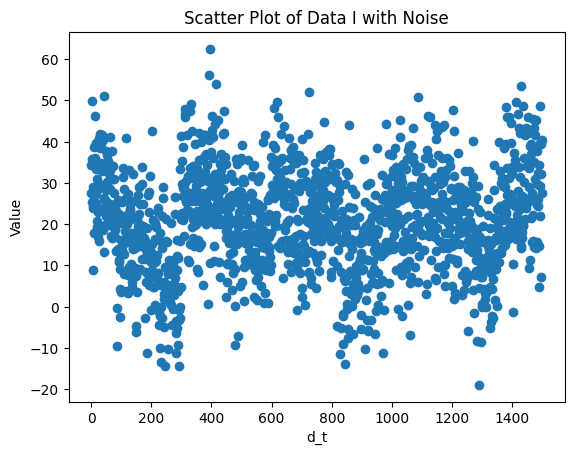

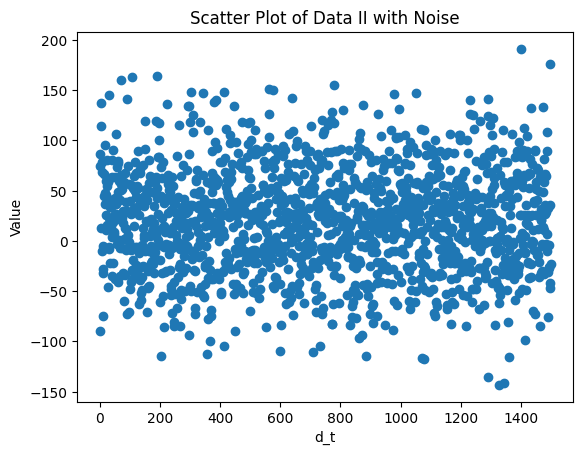

In [ ]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise_2)), Data_small_noise_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise_2)), Data_large_noise_2)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [ ]:
def model_func_3():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,-30), high=jnp.full(N_p*2,100)))
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise_2)
        return d_noised

nuts_kernel_3 = NUTS(model_func_3)
mcmc_3 = MCMC(nuts_kernel_3, num_warmup=100, num_samples=100)
mcmc_3.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 275.93it/s, 7 steps of size 5.49e-01. acc. prob=0.88] 


In [ ]:
def model_func_4():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*2,0), high=jnp.full(N_p*2,100)))
        # d = PM_converted @ s
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise_2)
        return d_noised

nuts_kernel_4 = NUTS(model_func_4)
mcmc_4 = MCMC(nuts_kernel_4, num_warmup=100, num_samples=100)
mcmc_4.run(rng_key)

(1500,)
(1500,)
(1500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(1500,)
(1500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 316.35it/s, 7 steps of size 6.87e-01. acc. prob=0.71]


In [ ]:
trace_3 = az.from_numpyro(mcmc_3)
trace_4 = az.from_numpyro(mcmc_4)

(1500,)
(1500,)
(1500,)
(1500,)


In [ ]:
trace_3.posterior['s'].squeeze().shape
trace_4.posterior['s'].squeeze().shape

(100, 20)

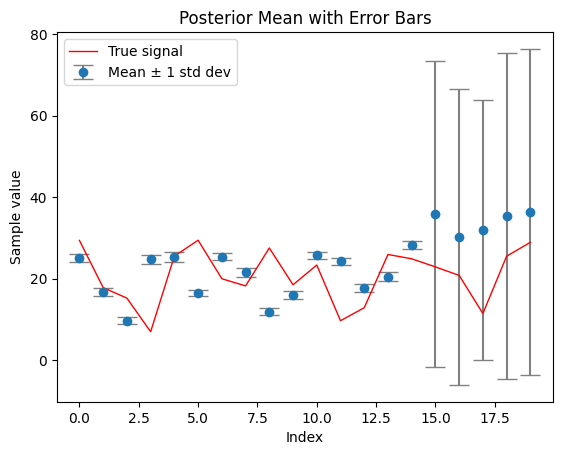

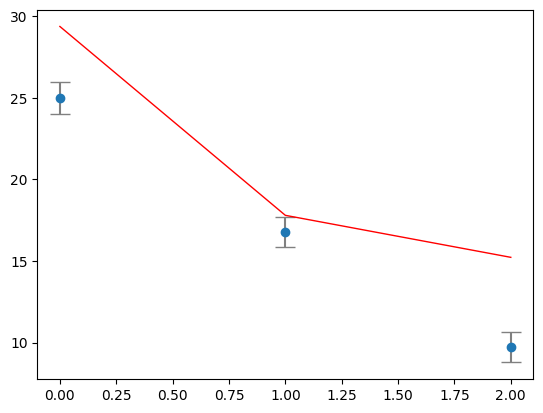

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_61912/1029122905.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


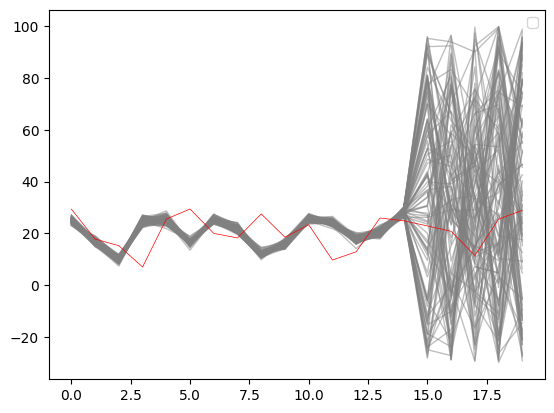

In [ ]:
s_samples_3 = trace_3.posterior['s'].squeeze().values
s_mean_3 = np.mean(s_samples_3, axis=0)
s_std_3 = np.std(s_samples_3, axis=0)

x = np.arange(len(s_mean_3))

plt.errorbar(x, s_mean_3, yerr=s_std_3, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:3], s_mean_3[0:3], yerr=s_std_3[0:3], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[0:3], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_3.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

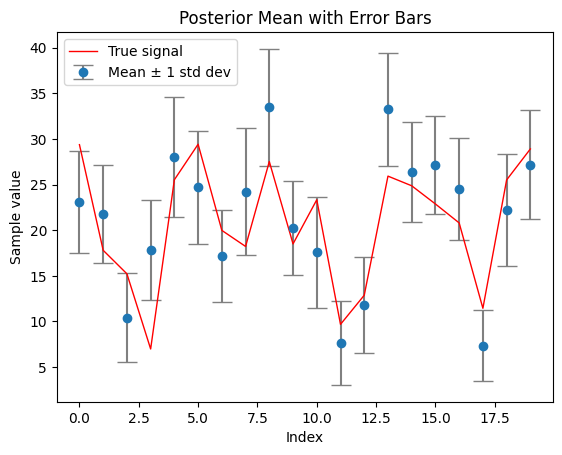

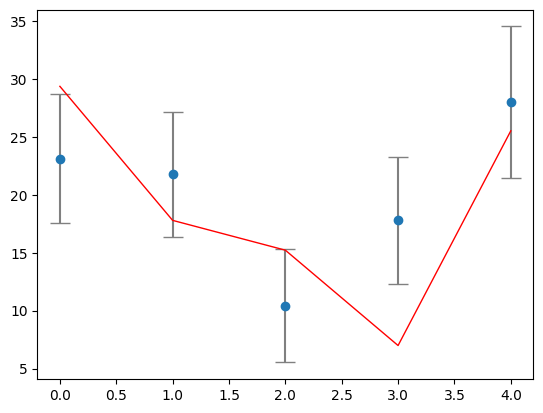

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_61912/777185513.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


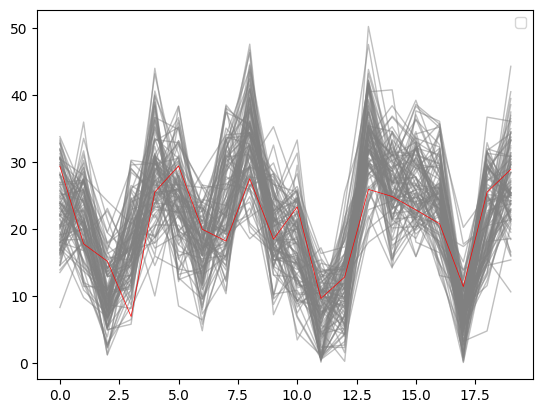

In [ ]:
s_samples_4 = trace_4.posterior['s'].squeeze().values
s_mean_4 = np.mean(s_samples_4, axis=0)
s_std_4 = np.std(s_samples_4, axis=0)

x = np.arange(len(s_mean_4))

plt.errorbar(x, s_mean_4, yerr=s_std_4, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_4[0:5], yerr=s_std_4[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_4.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

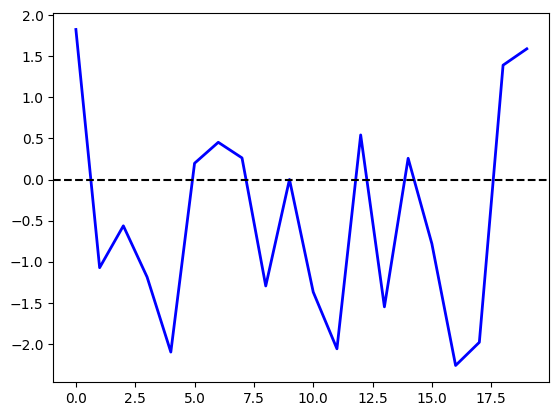

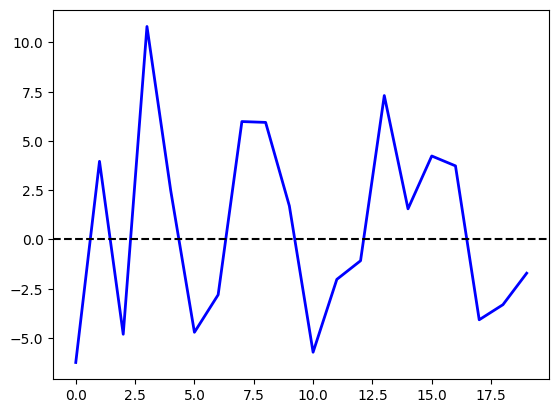

In [ ]:
plt.plot(s_mean_3 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

plt.plot(s_mean_4 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

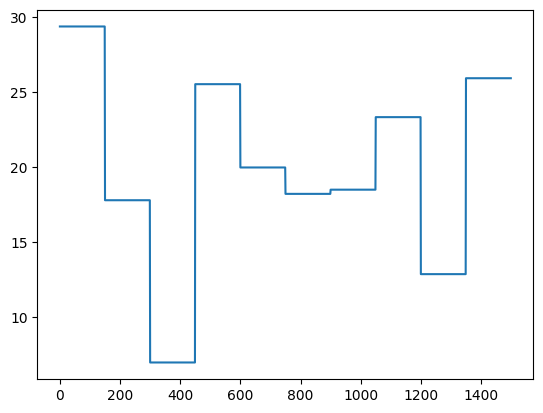

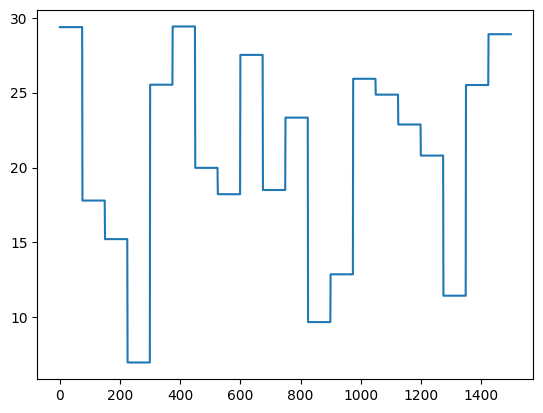

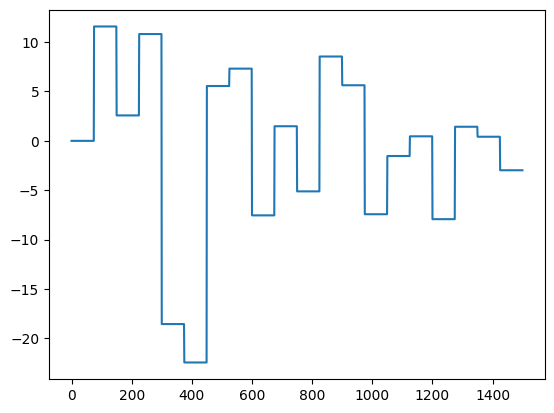

In [ ]:
# plt.plot(input_1)
# plt.show()
# plt.plot(input_2)
# plt.show()
# plt.plot(input_1-input_2)
# plt.show()